# Installing Libraries

In [1]:
!pip install keras

# Importing Libraries

In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax" 

import keras_cv
import keras
# from keras import ops
import tensorflow as tf
import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization, Flatten, Dense, Dropout,GlobalAveragePooling2D
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

2025-08-18 18:47:19.320551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755542839.514622      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755542839.572778      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    preset = "efficientnet"
    image_size = [400, 300]
    epochs = 30 
    batch_size = 64
    lr_mode = "cos"
    drop_remainder = True  # Drop incomplete batches
    num_classes = 6 # Number of classes in the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
    label2name = dict(enumerate(class_names))
    name2label = {v:k for k, v in label2name.items()}

In [4]:
keras.utils.set_random_seed(CFG.seed)

# Data Details

In [5]:
BASE_PATH = "/kaggle/input/hms-harmful-brain-activity-classification"

SPEC_DIR = "/tmp/dataset/hms-hbac"
os.makedirs(SPEC_DIR+'/train_spectrograms', exist_ok=True)
os.makedirs(SPEC_DIR+'/test_spectrograms', exist_ok=True)

In [6]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['eeg_path'] = f'{BASE_PATH}/train_eegs/'+df['eeg_id'].astype(str)+'.parquet'
df['spec_path'] = f'{BASE_PATH}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.parquet'
df['spec2_path'] = f'{SPEC_DIR}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.npy'
df['class_name'] = df.expert_consensus.copy()
df['class_label'] = df.expert_consensus.map(CFG.name2label)
display(df.head(2))

# Test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['eeg_path'] = f'{BASE_PATH}/test_eegs/'+test_df['eeg_id'].astype(str)+'.parquet'
test_df['spec_path'] = f'{BASE_PATH}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.parquet'
test_df['spec2_path'] = f'{SPEC_DIR}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.npy'
display(test_df.head(2))

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       42516          Seizure             3         0         0          0   
1       42516          Seizure             3         0         0          0   

   grda_vote  other_vote                                           eeg_path  \
0          0           0  /kaggle/input/hms-harmful-brain-activity-class...   
1          0           0  /kaggle/input/hms-harmful-brain-activity-class...   

                                           spec_path  \
0  /kaggle/input/hms-harmful-brain-activity-class...   
1  /kaggle/input/hms-harmful-brain-activity-class...   

                                          spec2_path class_name  class_label  
0  /tmp/dataset/hms-hbac/train_spectrograms/35373...    Seizure            0  
1  /tmp/dataset/hms-hbac/train_spectrograms/35373...    Seizure            0

spectrogram_id      eeg_id  patient_id  \
0          853520  3911565283        6885   

                                            eeg_path  \
0  /kaggle/input/hms-harmful-brain-activity-class...   

                                           spec_path  \
0  /kaggle/input/hms-harmful-brain-activity-class...   

                                          spec2_path  
0  /tmp/dataset/hms-hbac/test_spectrograms/853520...

In [7]:
df.isnull().sum()

eeg_id                              0
eeg_sub_id                          0
eeg_label_offset_seconds            0
spectrogram_id                      0
spectrogram_sub_id                  0
spectrogram_label_offset_seconds    0
label_id                            0
patient_id                          0
expert_consensus                    0
seizure_vote                        0
lpd_vote                            0
gpd_vote                            0
lrda_vote                           0
grda_vote                           0
other_vote                          0
eeg_path                            0
spec_path                           0
spec2_path                          0
class_name                          0
class_label                         0
dtype: int64

In [9]:
df.head(10)

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   
2  1628180742           2                       8.0          353733   
3  1628180742           3                      18.0          353733   
4  1628180742           4                      24.0          353733   
5  1628180742           5                      26.0          353733   
6  1628180742           6                      30.0          353733   
7  1628180742           7                      36.0          353733   
8  1628180742           8                      40.0          353733   
9  2277392603           0                       0.0          924234   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   
2                   2                               8.0  1142670488   
3                   3                              18.0  2718991173   
4                   4                              24.0  3080632009   
5                   5                              26.0  2413091605   
6                   6                              30.0   364593930   
7                   7                              36.0  3811483573   
8                   8                              40.0  3388718494   
9                   0                               0.0  1978807404   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       42516          Seizure             3         0         0          0   
1       42516          Seizure             3         0         0          0   
2       42516          Seizure             3         0         0          0   
3       42516          Seizure             3         0         0          0   
4       42516          Seizure             3         0         0          0   
5       42516          Seizure             3         0         0          0   
6       42516          Seizure             3         0         0          0   
7       42516          Seizure             3         0         0          0   
8       42516          Seizure             3         0         0          0   
9       30539              GPD             0         0         5          0   

   grda_vote  other_vote                                           eeg_path  \
0          0           0  /kaggle/input/hms-harmful-brain-activity-class...   
1          0           0  /kaggle/input/hms-harmful-brain-activity-class...   
2          0           0  /kaggle/input/hms-harmful-brain-activity-class...   
3          0           0  /kaggle/input/hms-harmful-brain-activity-class...   
4          0           0  /kaggle/input/hms-harmful-brain-activity-class...   
5          0           0  /kaggle/input/hms-harmful-brain-activity-class...   
6          0           0  /kaggle/input/hms-harmful-brain-activity-class...   
7          0           0  /kaggle/input/hms-harmful-brain-activity-class...   
8          0           0  /kaggle/input/hms-harmful-brain-activity-class...   
9          1           5  /kaggle/input/hms-harmful-brain-activity-class...   

                                           spec_path  \
0  /kaggle/input/hms-harmful-brain-activity-class...   
1  /kaggle/input/hms-harmful-brain-activity-class...   
2  /kaggle/input/hms-harmful-brain-activity-class...   
3  /kaggle/input/hms-harmful-brain-activity-class...   
4  /kaggle/input/hms-harmful-brain-activity-class...   
5  /kaggle/input/hms-harmful-brain-activity-class...   
6  /kaggle/input/hms-harmful-brain-activity-class...   
7  /kaggle/input/hms-harmful-brain-activity-class...   
8  /kaggle/input/hms-harmful-brain-activity-class...   
9  /kaggle/input/hms-harmful-brain-activity-class...   

                                          spec2_path class_name  class_label  
0  /tmp

In [10]:
def process_spec(spec_id, split="train"):
    spec_path = f"{BASE_PATH}/{split}_spectrograms/{spec_id}.parquet"
    spec = pd.read_parquet(spec_path)
    spec = spec.fillna(0).values[:, 1:].T # fill NaN values with 0, transpose for (Time, Freq) -> (Freq, Time)
    spec = spec.astype("float32")
    np.save(f"{SPEC_DIR}/{split}_spectrograms/{spec_id}.npy", spec)

# Get unique spec_ids of train and valid data
spec_ids = df["spectrogram_id"].unique()

# Parallelize the processing using joblib for training data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "train")
    for spec_id in tqdm(spec_ids,total=len(spec_ids))
)

# Get unique spec_ids of test data
test_spec_ids = test_df["spectrogram_id"].unique()

# Parallelize the processing using joblib for test data
_ = joblib.Parallel(n_jobs=-1, backend="loky")(
    joblib.delayed(process_spec)(spec_id, "test")
    for spec_id in tqdm(test_spec_ids, total=len(test_spec_ids))
)

  0%|          | 0/11138 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
# Shape of the dataset
df.shape

(106800, 20)

In [13]:
df.describe()

eeg_id     eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
count  1.068000e+05  106800.000000             106800.000000    1.068000e+05   
mean   2.104387e+09      26.286189                118.817228    1.067262e+09   
std    1.233371e+09      69.757658                314.557803    6.291475e+08   
min    5.686570e+05       0.000000                  0.000000    3.537330e+05   
25%    1.026896e+09       1.000000                  6.000000    5.238626e+08   
50%    2.071326e+09       5.000000                 26.000000    1.057904e+09   
75%    3.172787e+09      16.000000                 82.000000    1.623195e+09   
max    4.294958e+09     742.000000               3372.000000    2.147388e+09   

       spectrogram_sub_id  spectrogram_label_offset_seconds      label_id  \
count       106800.000000                     106800.000000  1.068000e+05   
mean            43.733596                        520.431404  2.141415e+09   
std            104.292116                       1449.759868  1.241670e+09   
min              0.000000                          0.000000  3.380000e+02   
25%              2.000000                         12.000000  1.067419e+09   
50%              8.000000                         62.000000  2.138332e+09   
75%             29.000000                        394.000000  3.217816e+09   
max           1021.000000                      17632.000000  4.294934e+09   

          patient_id   seizure_vote       lpd_vote       gpd_vote  \
count  106800.000000  106800.000000  106800.000000  106800.000000   
mean    32304.428493       0.878024       1.138783       1.264925   
std     18538.196252       1.538873       2.818845       3.131889   
min        56.000000       0.000000       0.000000       0.000000   
25%     16707.000000       0.000000       0.000000       0.000000   
50%     32068.000000       0.000000       0.000000       0.000000   
75%     48036.000000       1.000000       1.000000       0.000000   
max     65494.000000      19.000000      18.000000      16.000000   

           lrda_vote      grda_vote     other_vote    class_label  
count  106800.000000  106800.000000  106800.000000  106800.000000  
mean        0.948296       1.059185       1.966283       2.506217  
std         2.136799       2.228492       3.621180       1.764663  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000       1.000000  
50%         0.000000       0.000000       0.000000       3.000000  
75%         1.000000       1.000000       2.000000       4.000000  
max        15.000000      15.000000      25.000000       5.000000

In [14]:
# Check unique values of `expert_consensus`
df['expert_consensus'].unique()

array(['Seizure', 'GPD', 'LRDA', 'Other', 'GRDA', 'LPD'], dtype=object)

# Data Visualization

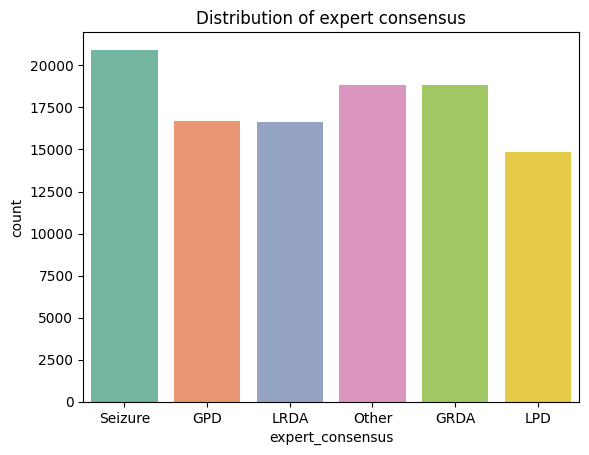

In [16]:
sns.countplot(x='expert_consensus', data=df, palette='Set2')  # can use palettes like 'Set1', 'Set2', 'pastel', etc.
plt.title('Distribution of expert consensus')
plt.show()


In [17]:
# Encode the `expert_consensus` column
label_encoder = LabelEncoder()
df['expert_consensus'] = label_encoder.fit_transform(df['expert_consensus'])

In [19]:
num_patients = df['patient_id'].nunique()
print(f"Number of unique patients in train dataset: {num_patients}")
num_eeg_ids = df['eeg_id'].nunique()
print(f"Number of unique EEG IDs in train dataset: {num_eeg_ids}")

Number of unique patients in train dataset: 1950
Number of unique EEG IDs in train dataset: 17089


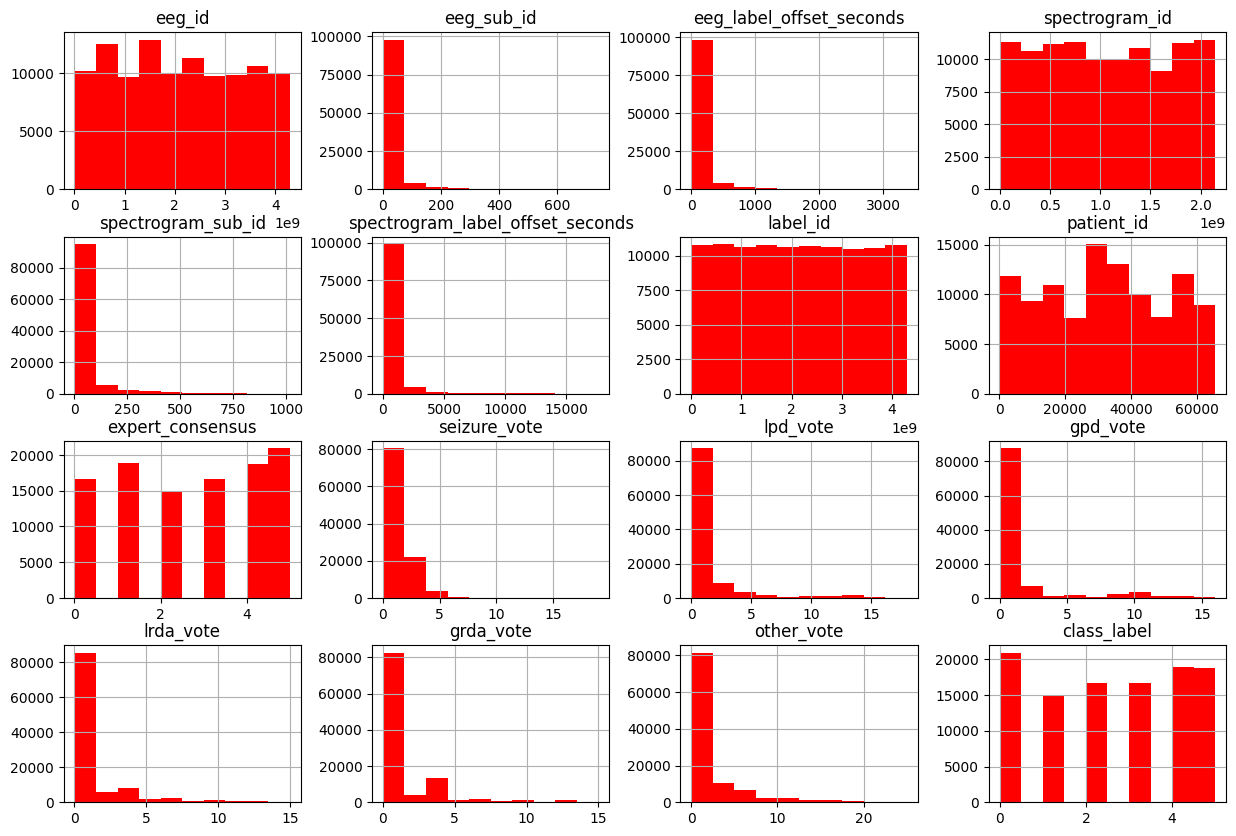

In [23]:
df.hist(figsize=(15, 10), color='red') 
plt.show()

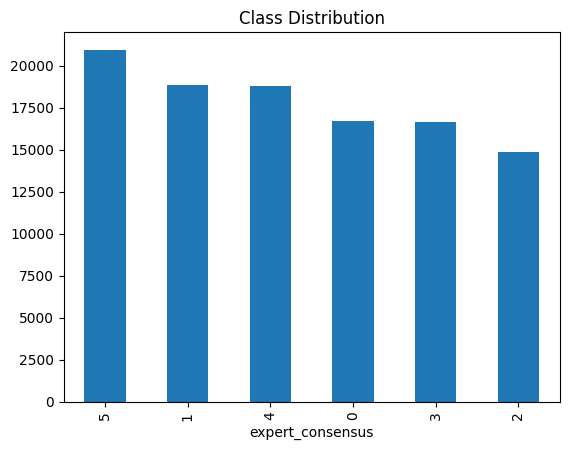

In [20]:
# Class Distribution
df['expert_consensus'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.show()

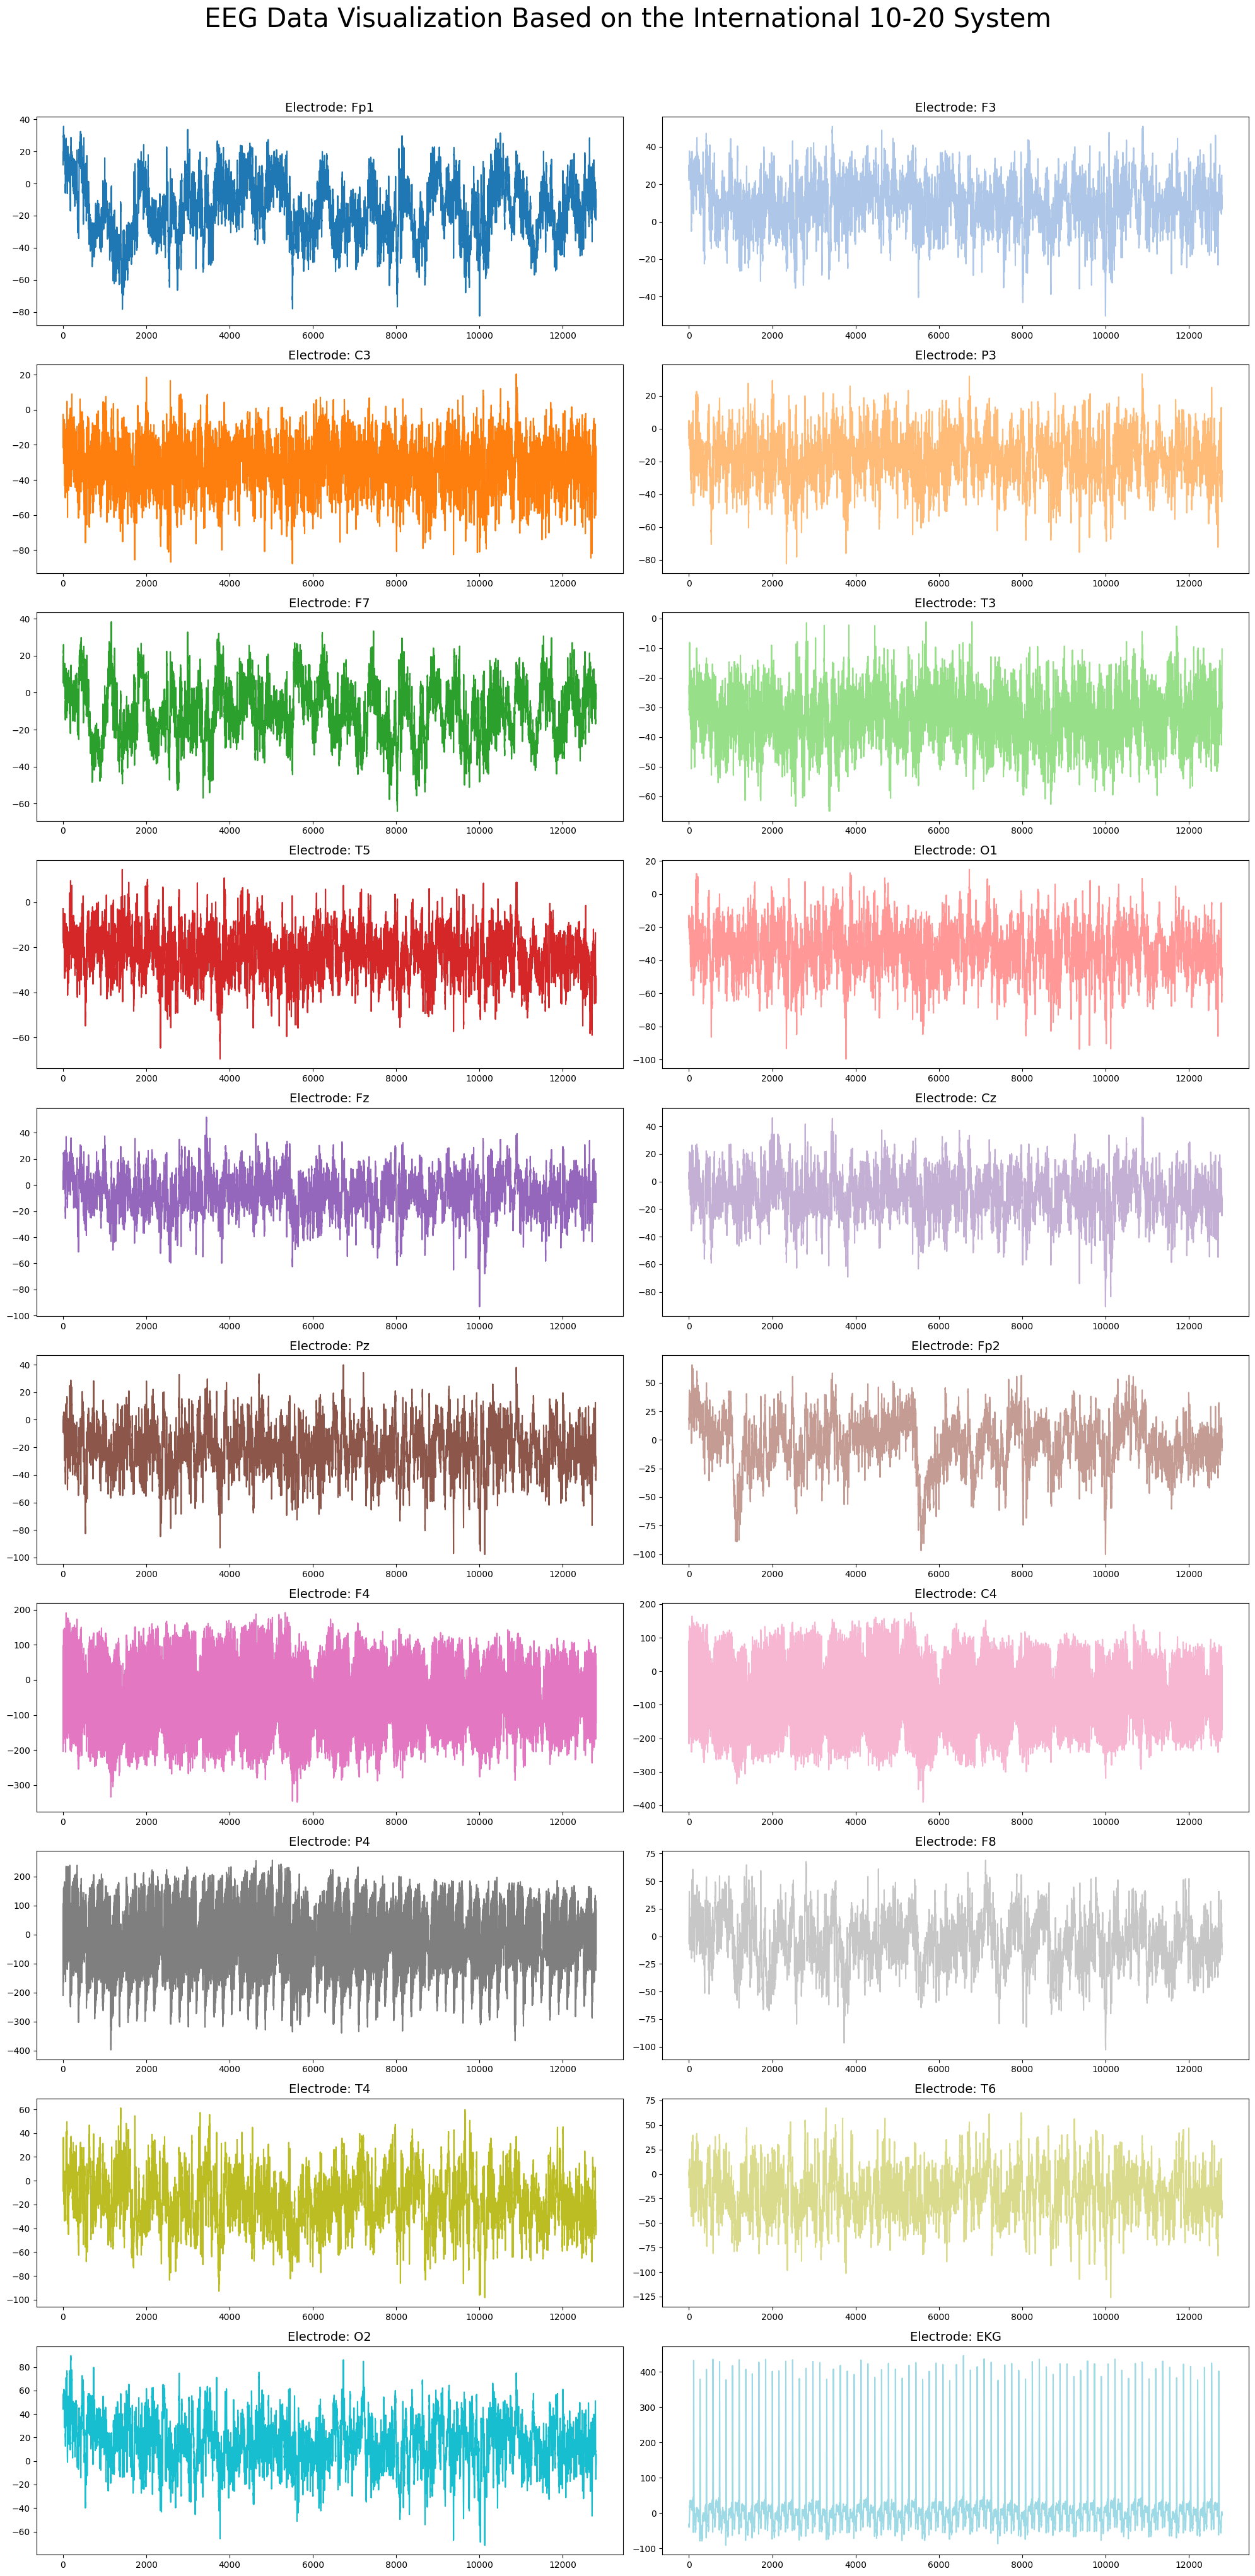

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Load EEG file
eeg = pd.read_parquet('/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/1484166292.parquet')

columns_to_plot = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 
                   'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']

num_plots = len(columns_to_plot)
num_columns = 2
num_rows = num_plots // num_columns + (num_plots % num_columns > 0)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 4))
axes = axes.flatten()

# Define a color palette
colors = plt.cm.tab20.colors  # 20 distinct colors

for i, col in enumerate(columns_to_plot):
    color = colors[i % len(colors)]  # cycle through colors if more than 20 channels
    axes[i].plot(eeg[col], color=color)
    axes[i].set_title(f'Electrode: {col}', fontsize=14)

for ax in axes[len(columns_to_plot):]:
    ax.set_visible(False)

fig.suptitle('EEG Data Visualization Based on the International 10-20 System', fontsize=30, y=1.02)
plt.tight_layout()
plt.show()


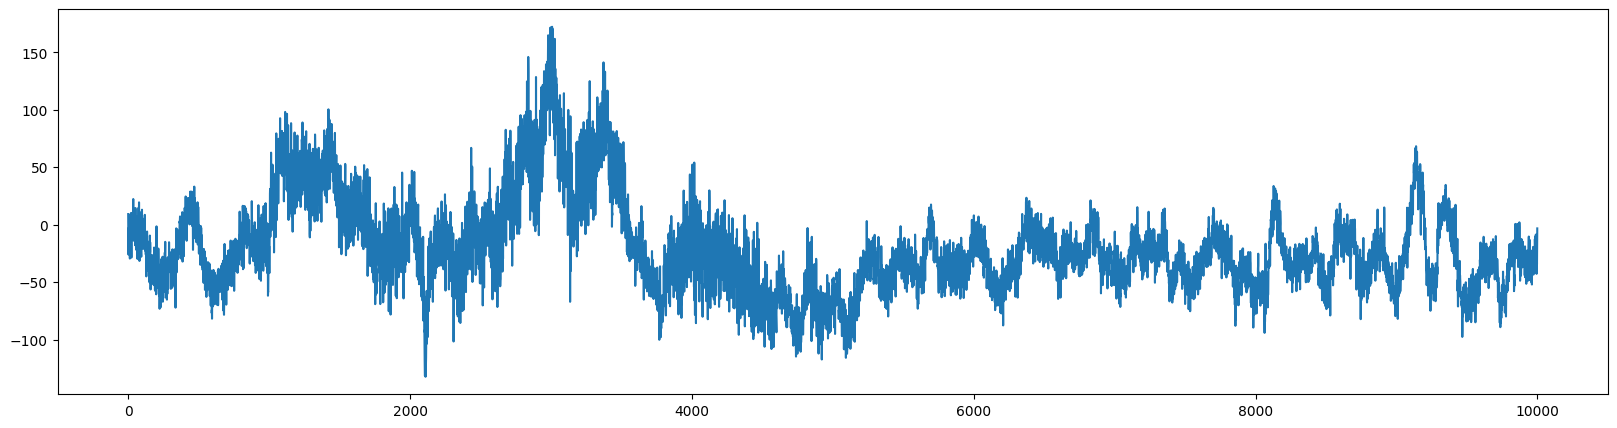

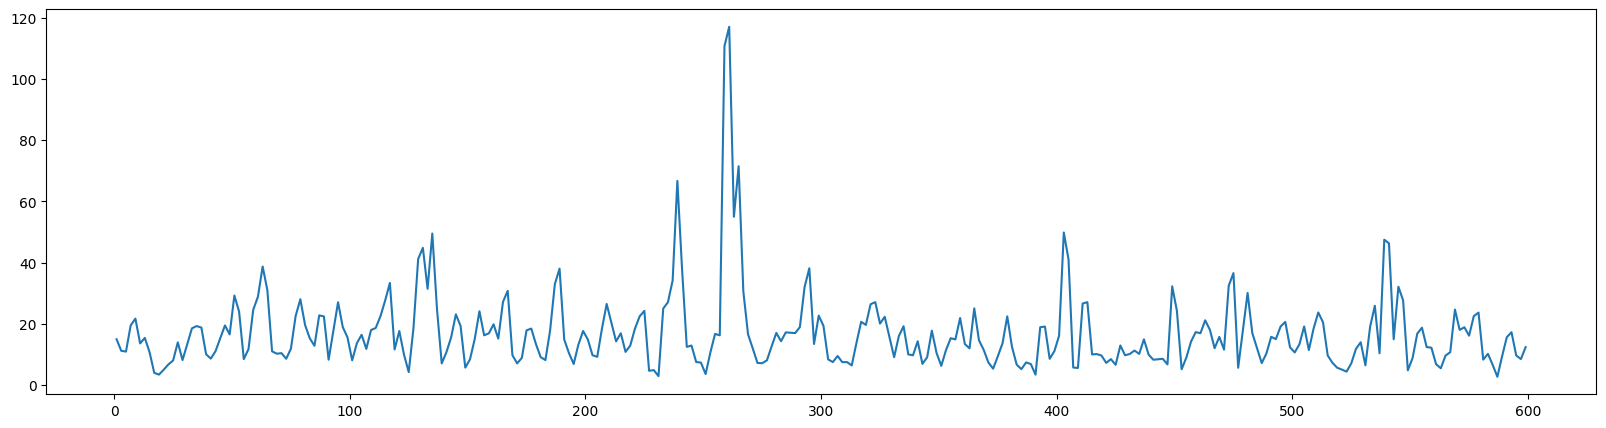

In [22]:
test_egg_id = 3911565283
test_spec_id = 853520

eeg_test = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/{test_egg_id}.parquet')    
plt.figure(figsize=(20,5))
plt.plot(eeg_test['Fp1'])

spec_test = pd.read_parquet(f'/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/{test_spec_id}.parquet')    
plt.figure(figsize=(20,5))
plt.plot(spec_test['time'], spec_test['LL_0.59'])

## Load data

In [36]:
def build_augmenter(dim=CFG.image_size):
    augmenters = [
        keras_cv.layers.MixUp(alpha=2.0),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.1)), # freq-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # time-masking
    ]
    
    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.5:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]
    
    return augment

In [37]:
def build_decoder(with_labels=True, target_size=CFG.image_size, dtype=32):
    def decode_signal(path, offset=None):
        # Read .npy files and process the signal
        file_bytes = tf.io.read_file(path)
        sig = tf.io.decode_raw(file_bytes, tf.float32)
        sig = sig[1024//dtype:]  # Remove header tag
        sig = tf.reshape(sig, [400, -1])
        
        # Extract labeled subsample from full spectrogram using "offset"
        if offset is not None: 
            offset = offset // 2  # Only odd values are given
            sig = sig[:, offset:offset+300]
            
            # Pad spectrogram to ensure the same input shape of [400, 300]
            pad_size = tf.math.maximum(0, 300 - tf.shape(sig)[1])
            sig = tf.pad(sig, [[0, 0], [0, pad_size]])
            sig = tf.reshape(sig, [400, 300])
        
        # Log spectrogram 
        sig = tf.clip_by_value(sig, tf.math.exp(-4.0), tf.math.exp(8.0)) # avoid 0 in log
        sig = tf.math.log(sig)
        # Normalize spectrogram
        sig -= tf.math.reduce_mean(sig)
        sig /= tf.math.reduce_std(sig) + 1e-6
        
        # Mono channel to 3 channels to use "ImageNet" weights
        sig = tf.tile(sig[..., None], [1, 1, 3])
        return sig
    
    def decode_label(label):
        label = tf.one_hot(label, CFG.num_classes)
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [CFG.num_classes])
        return label
    
    def decode_with_labels(path, offset=None, label=None):
        sig = decode_signal(path, offset)
        label = decode_label(label)
        return (sig, label)
    
    return decode_with_labels if with_labels else decode_signal

In [38]:
def build_dataset(paths, offsets=None, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=False, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter()
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths, offsets) if labels is None else (paths, offsets, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

## splitting data

In [39]:
from sklearn.model_selection import StratifiedGroupKFold

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

df["fold"] = -1
df.reset_index(drop=True, inplace=True)
for fold, (train_idx, valid_idx) in enumerate(
    sgkf.split(df, y=df["class_label"], groups=df["patient_id"])
):
    df.loc[valid_idx, "fold"] = fold
df.groupby(["fold", "class_name"])[["eeg_id"]].count().T

fold           0                                     1                    ...  \
class_name   GPD  GRDA   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA  ...   
eeg_id      2050  2605  1168  3793  3462    4007  4832  4856  4463  3117  ...   

fold           3                         4                                  
class_name   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA Other Seizure  
eeg_id      2318  4296  3884    4787  1889  3700  4249  3002  4013    4045  

[1 rows x 30 columns]

# Train and Validation Dataset

In [40]:
# Sample from full data
sample_df = df.groupby("spectrogram_id").head(1).reset_index(drop=True)
train_df = sample_df[sample_df.fold != CFG.fold]
valid_df = sample_df[sample_df.fold == CFG.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Train
train_paths = train_df.spec2_path.values
train_offsets = train_df.spectrogram_label_offset_seconds.values.astype(int)
train_labels = train_df.class_label.values
train_ds = build_dataset(train_paths, train_offsets, train_labels, batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, augment=True, cache=True)

# Valid
valid_paths = valid_df.spec2_path.values
valid_offsets = valid_df.spectrogram_label_offset_seconds.values.astype(int)
valid_labels = valid_df.class_label.values
valid_ds = build_dataset(valid_paths, valid_offsets, valid_labels, batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=True)

# Num Train: 9166 | Num Valid: 1972


I0000 00:00:1755543913.509660      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2612 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755543913.510356      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13940 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## Sample Images

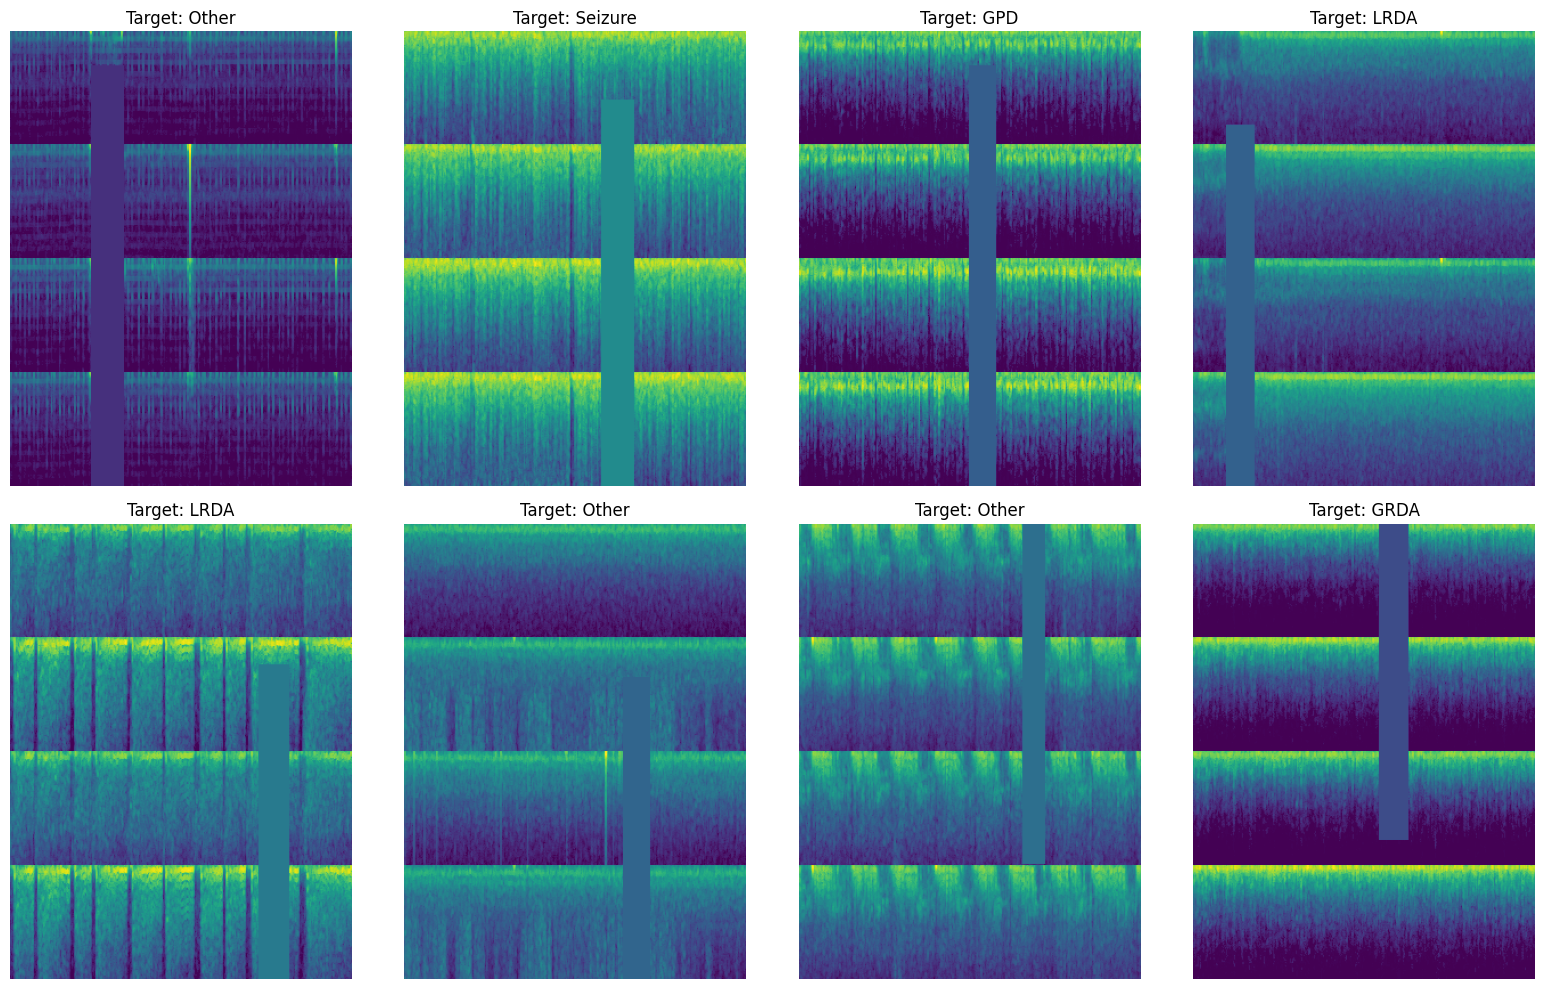

In [28]:
imgs, tars = next(iter(train_ds))

num_imgs = 8
plt.figure(figsize=(4*4, num_imgs//4*5))
for i in range(num_imgs):
    plt.subplot(num_imgs//4, 4, i + 1)
    img = imgs[i].numpy()[...,0]
    img /= img.max() + 1e-4
    tar = CFG.label2name[np.argmax(tars[i].numpy())]
    plt.imshow(img)
    plt.title(f"Target: {tar}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

# EfficientNet Model

In [30]:
LOSS = keras.losses.KLDivergence()

In [25]:
from keras.applications import EfficientNetB0
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model

In [26]:
base_model = EfficientNetB0(weights='imagenet', include_top=False)

INFO:2025-08-18 19:02:48,075:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-08-18 19:02:48,086:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(CFG.num_classes, activation='softmax')(x)


In [28]:
model = Model(inputs=base_model.input, outputs=x)


In [31]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=LOSS,
              metrics=['accuracy'])

# Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          7 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, None,      │          0 │ normalization[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, None,      │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ stem_conv_pad[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, None,      │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, None,      │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, None,      │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, None,      │          0 │ block1a_activati… │
│ (Multiply)          │ None, 32)         │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │        512 │ block1a_se_excit

 Total params: 4,057,257 (15.48 MB)

 Trainable params: 4,015,234 (15.32 MB)

 Non-trainable params: 42,023 (164.15 KB)

# LR Scheduling

In [32]:
import math
def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 6e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()
    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

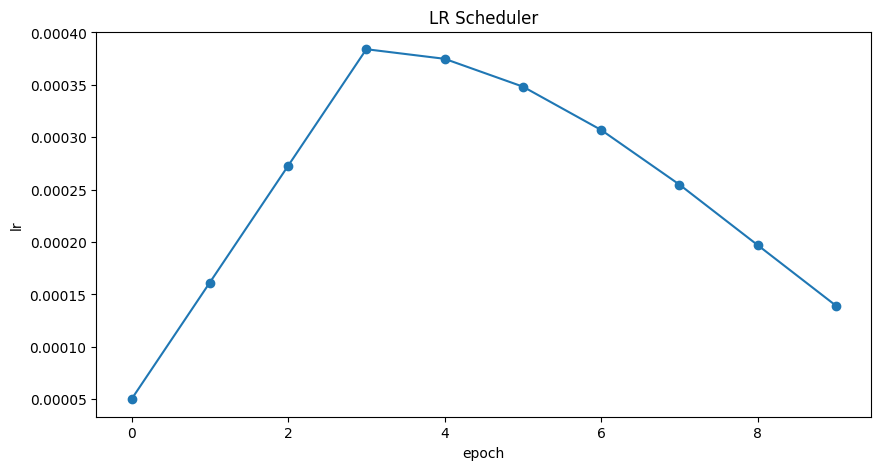

In [33]:
lr_cb = get_lr_callback(CFG.batch_size, mode=CFG.lr_mode, plot=True)

In [34]:
# Model Checkpoint Callback
ckpt_cb = keras.callbacks.ModelCheckpoint(f"best_model_efficientnet_custom_fold{CFG.fold}.keras",
                                           monitor='val_loss',
                                           save_best_only=True,
                                           save_weights_only=False,
                                           mode='min')

In [41]:
# Train the model
history = model.fit(train_ds,
                    epochs=CFG.epochs,
                    callbacks=[lr_cb, ckpt_cb],
                    steps_per_epoch=len(train_df) // CFG.batch_size,
                    validation_data=valid_ds,
                    verbose=CFG.verbose)

Epoch 1/30


2025-08-18 19:05:50.304374: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-18 19:05:50.621696: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-18 19:06:11.780889: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-18 19:06:11.972969: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-18 19:06:12.827621: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 0.3344 - loss: 1.4229

2025-08-18 19:09:17.065831: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-18 19:09:17.357689: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


143/143 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.3349 - loss: 1.4220 - val_accuracy: 0.1131 - val_loss: 1.8753 - learning_rate: 5.0000e-05
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 137s 778ms/step - accuracy: 0.5565 - loss: 1.0558 - val_accuracy: 0.4204 - val_loss: 1.7411 - learning_rate: 1.6133e-04
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 108s 757ms/step - accuracy: 0.6253 - loss: 0.9296 - val_accuracy: 0.4635 - val_loss: 1.8000 - learning_rate: 2.7267e-04
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 110s 766ms/step - accuracy: 0.6506 - loss: 0.8271 - val_accuracy: 0.4665 - val_loss: 1.6145 - learning_rate: 3.8400e-04
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 108s 758ms/step - accuracy: 0.7034 - loss: 0.7469 - val_accuracy: 0.4802 - val_loss: 2.4555 - learning_rate: 3.7485e-04
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 109s 759ms/step - accuracy: 0.7150 - loss: 0.6977 - val_accuracy: 0.4833 - val_loss: 1.9127 - learning_rate: 3.4829e-04
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 109s 766ms/ste

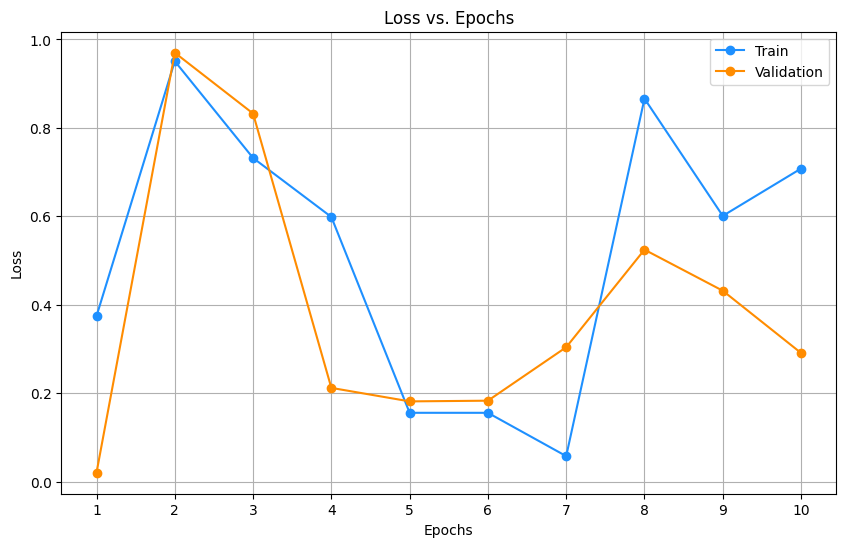

In [46]:
import matplotlib.pyplot as plt
import numpy as np

def display_training_curves(training, validation, yaxis):
    epochs = len(training)
    x = np.arange(1, epochs + 1)
    
    plt.figure(figsize=(10, 6))
    
    if yaxis == "loss":
        plt.plot(x, training, marker='o', color='dodgerblue', label='Train')
        plt.plot(x, validation, marker='o', color='darkorange', label='Validation')
        plt.ylabel("Loss")
        plt.title("Loss vs. Epochs")
    else:
        plt.plot(x, training, marker='o', color='dodgerblue', label='Train')
        plt.plot(x, validation, marker='o', color='darkorange', label='Validation')
        plt.ylabel("Accuracy")
        plt.title("Accuracy vs. Epochs")
        
    plt.xlabel("Epochs")
    plt.xticks(x)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
train_loss = np.random.rand(10)
val_loss = np.random.rand(10)
display_training_curves(train_loss, val_loss, yaxis="loss")


2025-08-18 20:05:35.334305: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-18 20:05:35.569731: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━

2025-08-18 20:05:50.524947: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-18 20:05:50.731206: E external/xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step 


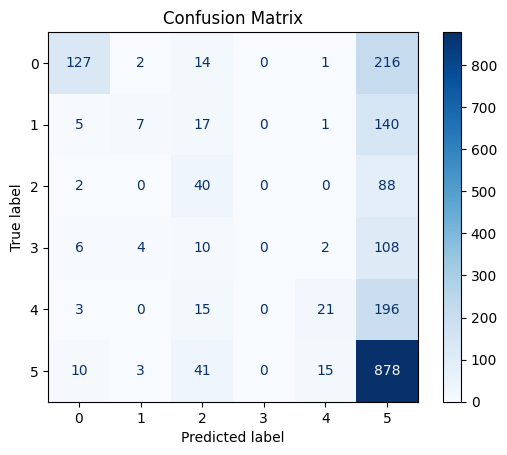

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# 1. Get predictions
y_true = []
y_pred = []

for x_batch, y_batch in valid_ds:  # or test_ds if you have
    preds = model.predict(x_batch)
    y_true.extend(np.argmax(y_batch, axis=1))  # if one-hot encoded
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
